In [100]:
#-------------------------------------------------------IMPORT----------------------------------------------------------------------------#
#dieu
import numpy as np
import pandas as pd
import string
# Sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import recall_score , precision_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import f1_score
#vis
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#NLP
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer  
#os
import time
start_time = time.time()

In [29]:
df1 = pd.read_csv('../data/emotion_final.csv')

x_df1 = df1['Text'] ## Text content as Corpus
y_df1 = df1['Emotion'] ## Emotion as Corpus

print(df1.head())
print(df1['Emotion'].unique())
df_count_emotion = df1.groupby(['Emotion']).size().reset_index(name='Count')
print(df_count_emotion)
df1.head()  

                                                Text  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
['sadness' 'anger' 'love' 'surprise' 'fear' 'happy']
    Emotion  Count
0     anger   2993
1      fear   2652
2     happy   7029
3      love   1641
4   sadness   6265
5  surprise    879


,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


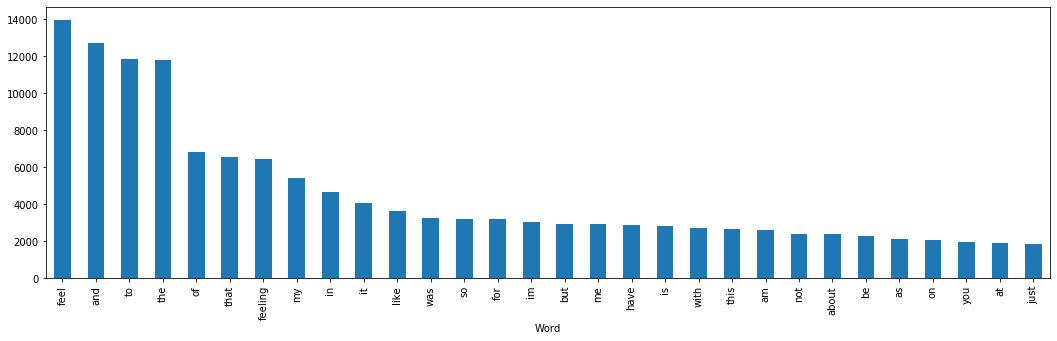

In [30]:
#-----------------------------------------------------------FUNCTIONS--------------------------------------------------------------------#
def get_top_n_words(corpus,d,n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    if d == "up" :
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]
    elif d == "down" :
        words_freq=sorted(words_freq, key = lambda x: x[1], reverse=False)
        return words_freq[:n]

freq_top = get_top_n_words(x_df1,"up",100)
freq_down = get_top_n_words(x_df1,"down",100)

df_up = pd.DataFrame(freq_top, columns =['Word','Number of times'])
df_down = pd.DataFrame(freq_down, columns =['Word','Number of times'])
df_up.groupby('Word')['Number of times'].sum().sort_values(ascending=False).head(30).plot(kind='bar', figsize = (18,5))
# sns.distplot(df_up['Number of times']).set(title='Most used words',xlabel='Words',ylabel='Number of times')

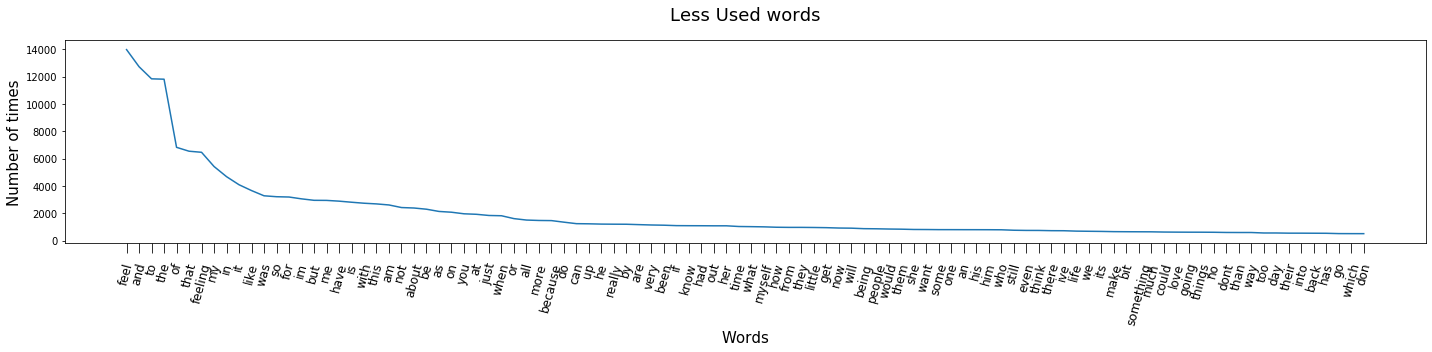

In [31]:
y_nbr = df_up['Number of times']
x_word = df_up['Word']
fig, ax = plt.subplots(figsize=(20, 5),tight_layout=True)
ax.set_title('Less Used words',size=18,pad=20)
ax.set_xlabel('Words',size=15)
ax.set_ylabel('Number of times',size=15)
ax.plot(x_word, y_nbr)
ax.tick_params(axis='x',labelsize=12,pad=8,size=10, rotation=75)
plt.show()

In [32]:
#------------------------------------------------------DATAFRAME DISPLAY------------------------------------------------------------------#
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)
pd.reset_option("^display") ##Reset display option

In [43]:
df1.Text = df1['Text'].str.lower()
df1['tokenized_sents'] = df1.apply(lambda row: word_tokenize(row['Text']), axis=1)
stop_sw = stopwords.words('english')
df1['tokenized_sents'] = df1['tokenized_sents'].apply(lambda x: [item for item in x if item not in stop_sw])
df1

,Text,Emotion,tokenized_sents
0,i didnt feel humiliated,sadness,"[didnt, feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,sadness,"[go, feeling, hopeless, damned, hopeful, aroun..."
2,im grabbing a minute to post i feel greedy wrong,anger,"[im, grabbing, minute, post, feel, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplac...,love,"[ever, feeling, nostalgic, fireplace, know, st..."
4,i am feeling grouchy,anger,"[feeling, grouchy]"
...,...,...,...
21454,melissa stared at her friend in dism,fear,"[melissa, stared, friend, dism]"
21455,successive state elections have seen the gover...,fear,"[successive, state, elections, seen, governing..."
21456,vincent was irritated but not dismay,fear,"[vincent, irritated, dismay]"
21457,kendall-hume turned back to face the dismayed ...,fear,"[kendall-hume, turned, back, face, dismayed, c..."


In [115]:
nltk.download()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
...,...,...,...,...
39995,1753918954,neutral,showMe_Heaven,@JohnLloydTaylor
39996,1753919001,love,drapeaux,Happy Mothers Day All my love
39997,1753919005,love,JenniRox,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,ipdaman1,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [118]:
df2 = pd.read_csv('../data/text_emotion.csv')

df2.content = df2.content.str.lower() # lowercase

exclude = set(string.punctuation) # exclude = punctuation strings
stop_sw = stopwords.words('english') # we choosing stop words of english dict
stop_sw.extend(exclude) # we add strings punctions to stop word dict

stemmer = SnowballStemmer("english") # we choosing the language english for the stemmization 
porter = PorterStemmer() 
lancaster=LancasterStemmer()

df2['tokenized_sents'] = df2.apply(lambda row: word_tokenize(row['content']), axis=1) # Tokenization
df2['tokenized_sents'] = df2['tokenized_sents'].apply(lambda x: [item for item in x if item not in stop_sw])

df2.tokenized_sents = [[lemma.lemmatize(word) for word in each if word not in stop_sw] for each in df2.tokenized_sents] # delete stop word for each token



df2['tokenized_sents'] = df2['tokenized_sents'].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
df2['tokenized_sents'] = df2['tokenized_sents'].apply(lambda x: [porter.stem(y) for y in x]) # Stem every word.
df2['tokenized_sents'] = df2['tokenized_sents'].apply(lambda x: [lancaster.stem(y) for y in x]) # Stem every word.
df2

,tweet_id,sentiment,author,content,tokenized_sents
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,"[tiffanylu, know, listenin, bad, habit, ear, s..."
1,1956967666,sadness,wannamama,layin n bed with a headache ughhhh...waitin o...,"[layin, n, bed, headach, ughhhh, ..., waitin, ..."
2,1956967696,sadness,coolfunky,funeral ceremony...gloomy friday...,"[fun, ceremon, ..., gloom, friday, ...]"
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends soon!,"[want, hang, friend, soon]"
4,1956968416,neutral,xkilljoyx,@dannycastillo we want to trade with someone w...,"[dannycastillo, want, trad, someon, houston, t..."
...,...,...,...,...,...
39995,1753918954,neutral,showMe_Heaven,@johnlloydtaylor,[johnlloydtayl]
39996,1753919001,love,drapeaux,happy mothers day all my love,"[happ, moth, day, lov]"
39997,1753919005,love,JenniRox,happy mother's day to all the mommies out ther...,"[happ, moth, 's, day, momm, wom, man, long, re..."
39998,1753919043,happiness,ipdaman1,@niariley wassup beautiful!!! follow me!! pee...,"[niariley, wassup, beaut, follow, peep, new, h..."
